In [1]:
!pip install transformers torch timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Image Segmentation with U-Net

It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class.

<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%203/Image%20Segmentation%20Unet/images/carseg.png?raw=true" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

In [ ]:
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path + i for i in image_list]
mask_list = [mask_path + i for i in mask_list]

Text(0.5, 1.0, 'Segmentation')

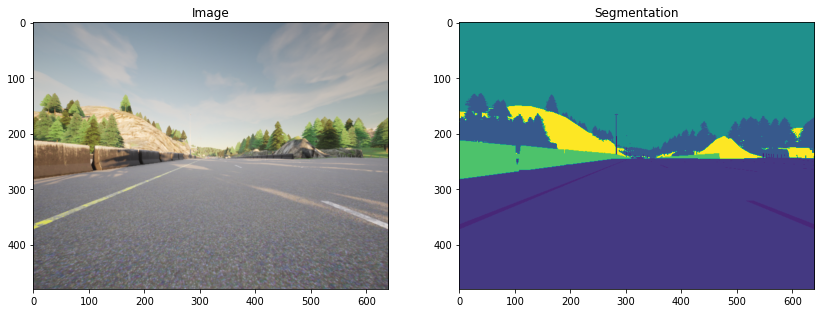

In [ ]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
# mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### Split Your Dataset into Unmasked and Masked Images

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/002128.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/002128.png', shape=(), dtype=string)


In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')
    input_image = input_image / 255.
    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

## U-Net 

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 

### Model Details

<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%203/Image%20Segmentation%20Unet/images/unet.png?raw=true" style="width:700px;height:200;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total. 

### Encoder (Downsampling Block) 

<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%203/Image%20Segmentation%20Unet/images/encoder.png?raw=true" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    # (m, 96, 128, 3) --> (m, 96, 128, 32)
    conv = Conv2D(filters=n_filters,
                  kernel_size=3,  
                  activation='relu',
                  padding="same",
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)

    #  (m, 96, 128, 32)
    conv = Conv2D(filters=n_filters,
                  kernel_size=3,  
                  activation='relu',
                  padding="same",
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
         
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    # (m, 48, 64, 32)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), 
                                               strides=None, 
                                               padding='valid', data_format=None)(conv)
        
    else:
        next_layer = conv

    skip_connection = conv
    
    # (m, 48, 64, 32), (m, 96, 128, 32)
    return next_layer, skip_connection

In [ ]:
### without dropout and pooling
input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

print('Block 1:')
for layer in summary(model1):
    print(layer)

### with dropout and pooling
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)
print('\nBlock 2:')   
for layer in summary(model2):
    print(layer)

Block 1:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]
All tests passed!

Block 2:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 96, 128, 1024), 0, 0.1]
['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]
All tests passed!


### Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%203/Image%20Segmentation%20Unet/images/decoder.png?raw=true" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>


In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    # (m, 12, 16, 256) --> (m, 24, 32, 32)
    up = Conv2DTranspose(filters=n_filters,   
                         kernel_size=3,   
                         strides=2,
                         padding="same")(expansive_input)
    
    # Merge the previous output and the contractive_input
    # (m, 24, 32, 32) + (m, 24, 32, 128) = (m, 24, 32, 160)
    merge = concatenate([up, contractive_input], axis=3)

    # (m, 24, 32, 32)
    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,   
                  activation='relu',
                  padding="same",
                  kernel_initializer=tf.keras.initializers.HeNormal())(merge)

    # (m, 24, 32, 32)
    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,   
                  activation='relu',
                  padding="same",
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)    
    return conv

In [ ]:
input_size1 = (12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

print('Block 1:')
for layer in summary(model1):
    print(layer)

Block 1:
['InputLayer', [(None, 12, 16, 256)], 0]
['Conv2DTranspose', (None, 24, 32, 32), 73760]
['InputLayer', [(None, 24, 32, 128)], 0]
['Concatenate', (None, 24, 32, 160), 0]
['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
All tests passed!


### Build the Model

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)

    ### Contracting Path (encoding)
    # (m, 96, 128, 3) --> (m, 48, 64, 32)
    cblock1 = conv_block(inputs, n_filters)

    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # (m, 24, 32, 64)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    # (m, 12, 16, 128)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    # (m, 6, 8, 256)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob= 0.3) 

    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    # # (m, 6, 8, 512)
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False) 
    
    ### Expanding Path (decoding)
    # (m, 6, 8, 512), (m, 12, 16, 256) --> (m, 12, 16, 256)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)

    # (m, 24, 32, 128)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)

    # (m, 48, 64, 64)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)

    # (m, 96, 128, 32)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    # (m, 96, 128, 32)
    conv9 = Conv2D(filters=n_filters, 
                   kernel_size=3, 
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9)

    # (m, 96, 128, 23)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)    
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [ ]:
img_height = 96
img_width = 128
num_channels = 3
unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 96, 128, 32)  896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 96, 128, 32)  9248        conv2d_26[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 48, 64, 32)   0           conv2d_27[0][0]                  
_______________________________________________________________________________________

### Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


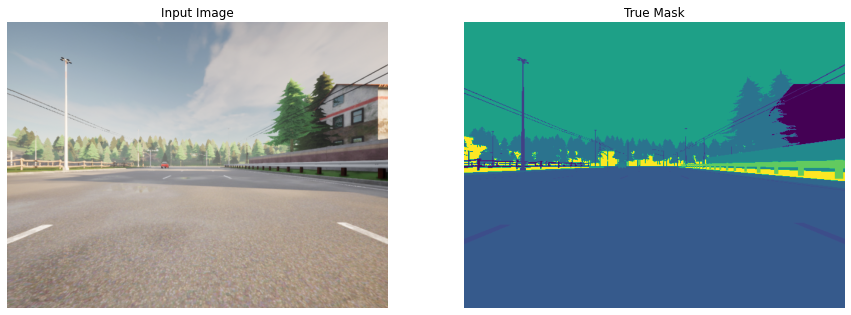

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


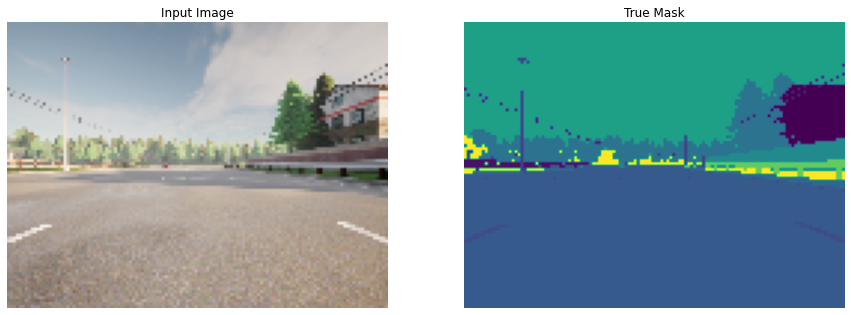

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

## Train the Model

In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 14s 410ms/step - loss: 3.1221 - accuracy: 0.3403
Epoch 2/40
34/34 [==============================] - 1s 41ms/step - loss: 1.6778 - accuracy: 0.4912
Epoch 3/40
34/34 [==============================] - 1s 40ms/step - loss: 0.9051 - accuracy: 0.7545
Epoch 4/40
34/34 [==============================] - 1s 40ms/step - loss: 0.7784 - accuracy: 0.7630
Epoch 5/40
34/34 [==============================] - 1s 40ms/step - loss: 0.7185 - accuracy: 0.7786
Epoch 6/40
34/34 [==============================] - 1s 40ms/step - loss: 0.6724 - accuracy: 0.7894
Epoch 7/40
34/34 [==============================] - 1s 40ms/step - loss: 0.6332 - accuracy: 0.7974
Epoch 8/40
34/34 [==============================] - 1s 40ms/step - loss: 0.5964 - accuracy: 0.8064
Epoch 9/40
34/34 [==============================] - 1s 40ms/step - loss: 0.5509 - acc

### Create Predicted Masks 

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did! 

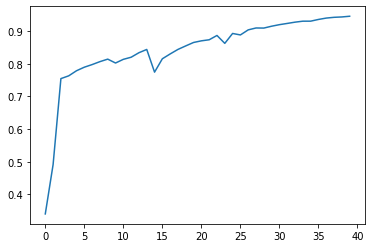

In [ ]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

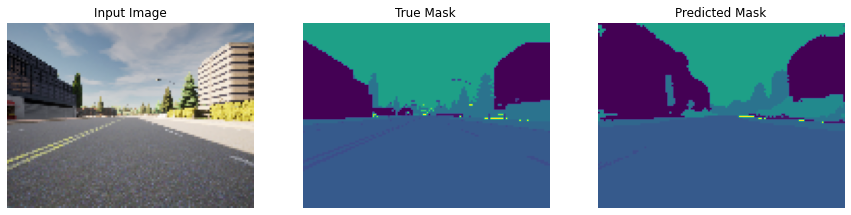

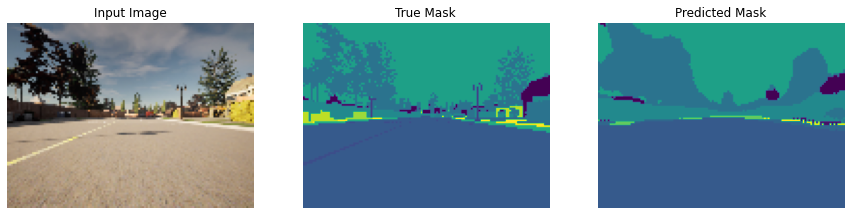

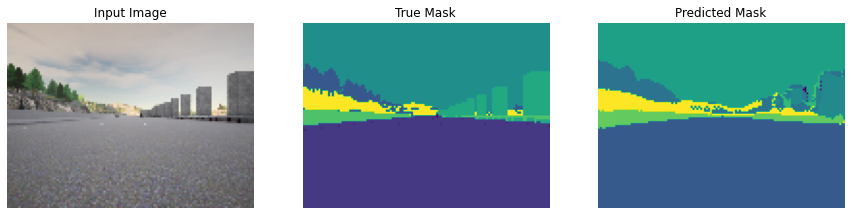

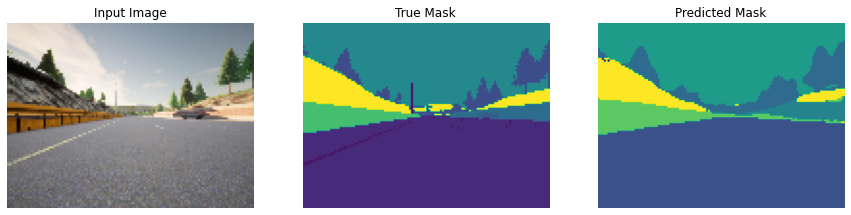

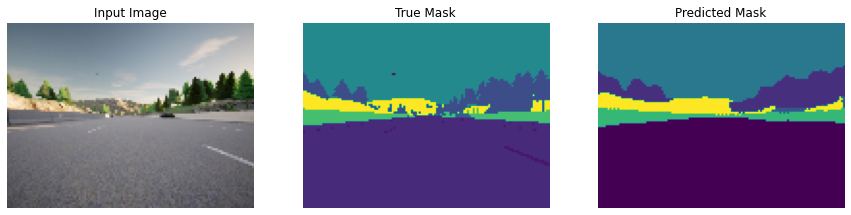

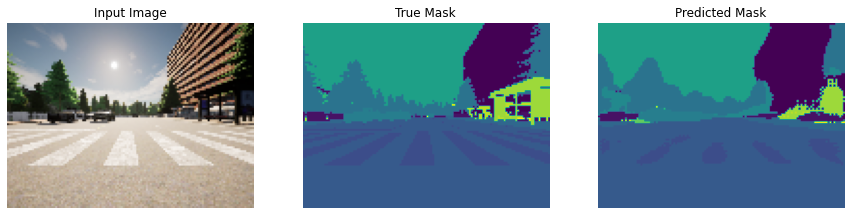

In [ ]:
show_predictions(train_dataset, 6)

With 40 epochs you get amazing results!


<font color='blue'>
    
**What you should remember**: 

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net

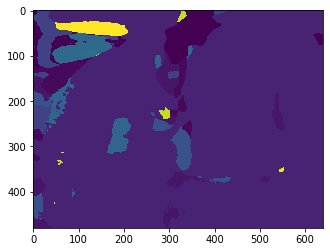

In [9]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch
from matplotlib import pyplot as plt

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg  = upsampled_logits.argmax(dim=1)[0]
plt.imshow(pred_seg, interpolation='nearest')
plt.show()